In [50]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
pd.set_option('display.max_columns', None)


In [51]:
df = pd.read_stata('lendingclub_train.dta')
# df.head()
# df.describe()
columns_to_drop = [
    "index",
    "depvar",
    "total_acc", 
    "out_prncp", 
    "out_prncp_inv", 
    "total_pymnt", 
    "total_pymnt_inv", 
    "total_rec_prncp", 
    "total_rec_int", 
    "total_rec_late_fee", 
    "recoveries", 
    "collection_recovery_fee",
    "last_pymnt_amnt", 
    "last_fico_range_high", 
    "last_fico_range_low", 
    "tot_coll_amt", 
    "tot_cur_bal", 
    "initial_list_status1", 
    "initial_list_status2", 
    "elapsed_t",
    "purpose1",
    "addr_state1",
    "elapsed_t",
    "debt_settlement_flag1",
    "term1",
    "mths_since_last_delinq1",
    "mths_since_last_major_derog1",
    "mths_since_last_record1",
    "mths_since_rcnt_il1",
    "mths_since_recent_bc1",
    "mths_since_recent_bc_dlq1",
    "mths_since_recent_inq1",
    "mths_since_recent_revol_delinq1"
]

issue_d_count = 1
while(issue_d_count <= 118):
    word_tmp = "issue_d" + str(issue_d_count)
    columns_to_drop.append(word_tmp)
    issue_d_count += 1


### Undersampling Logic
Undersampling을 안할거면 다음 로직 실행

In [52]:
# Separate majority and minority classes
df_majority = df[df['depvar'] == 0]
df_minority = df[df['depvar'] == 1]

# Count number of instances in the minority class
minority_count = len(df_minority)

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=minority_count, random_state=42)

# Combine minority class with the undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the dataset
df_undersampled = df_undersampled.sample(frac=1, random_state=42)

# Now split into features and target, and then into training and testing sets
y = df_undersampled['depvar']
X = df_undersampled.drop(columns=columns_to_drop)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# X.info(verbose=True,max_cols=None)
# y.head()
# X.head()


In [45]:
# y = df['depvar']
# X = df.drop(columns=columns_to_drop)
# # X = df.drop(columns=['depvar','index'])

# X.info(verbose=True,max_cols=None)

# Hyperparameter Tuning

In [54]:
# Compute class weights for the tuning subset
# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
# class_weight_dict = dict(enumerate(class_weights))

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=16, max_value=512, step=16), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=512, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))  # Single output neuron

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',  # Binary crossentropy loss
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='hyperband_tuning'
)

tuner.search(
    X_train, y_train, 
    epochs=10, validation_data=(X_val, y_val), batch_size = 256
    # , class_weight=class_weight_dict
    )

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Accuracy: {accuracy:.2f}, Test Loss: {loss:.2f}")

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Prepare the best hyperparameters for saving
best_hyperparameters = {
    'units': best_hps.get('units'),
    'units2': best_hps.get('units2'),
    'dropout': best_hps.get('dropout'),
    'dropout2': best_hps.get('dropout2'),
    'learning_rate': best_hps.get('learning_rate')
}

# Save the best hyperparameters to a JSON file
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

print("Best hyperparameters saved to 'best_hyperparameters.json'")

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.5353166460990906

Best val_accuracy So Far: 0.5621548295021057
Total elapsed time: 00h 03m 18s
1772/1772 [==============================] - 1s 457us/step - loss: 0.7056 - accuracy: 0.5622
Test Accuracy: 0.56, Test Loss: 0.71
Best hyperparameters saved to 'best_hyperparameters.json'


# Model Training

In [56]:
# Class Weight
# class_weights = compute_class_weight('balanced', classes=[0,1], y=y_train)
# class_weight_dict = dict(enumerate(class_weights))


# Load best hyperparameters
with open('best_hyperparameters.json') as f:
    best_hps = json.load(f)

model_path = 'final_trained_model.h5'
if(os.path.exists(model_path)):
    model = load_model(model_path)
else:
    model = Sequential()
    model.add(Dense(units=best_hps['units'], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(best_hps['dropout']))
    model.add(Dense(units=best_hps['units2'], activation='relu'))
    model.add(Dropout(best_hps['dropout2']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(X, y, epochs=200, batch_size=256
                    # , class_weight=class_weight_dict
                    )  # Adjust epochs and batch_size as needed

# Save the final trained model
model.save('final_trained_model.h5')


Epoch 1/200
1107/1107 [==============================] - 3s 2ms/step - loss: 40.9154 - accuracy: 0.5083
Epoch 2/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.6911 - accuracy: 0.5253
Epoch 3/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.6928 - accuracy: 0.5127
Epoch 4/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.7743 - accuracy: 0.5028
Epoch 5/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.6969 - accuracy: 0.4986
Epoch 6/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.9179 - accuracy: 0.4997
Epoch 7/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.6945 - accuracy: 0.4987
Epoch 8/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.5003
Epoch 9/200
1107/1107 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.5006
Epoch 10/200
1107/1107 [==============================] - 2s 2ms/step - 

/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plot the learning 

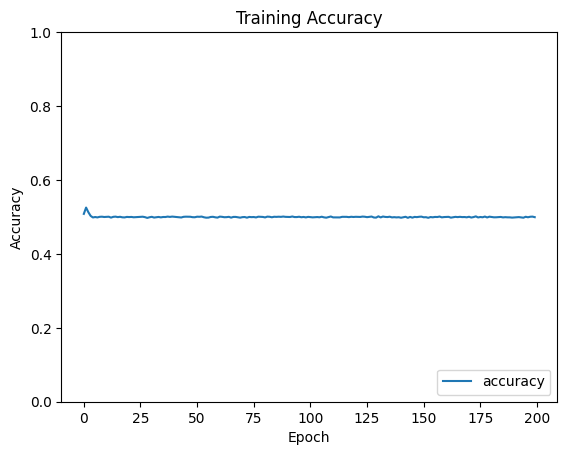

1772/1772 - 1s - loss: 0.6931 - accuracy: 0.5013 - 895ms/epoch - 505us/step
Test accuracy: 0.5013056993484497
1772/1772 [==============================] - 1s 443us/step
Confusion Matrix:
 [[    0 28263]
 [    0 28411]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     28263
         1.0       0.50      1.00      0.67     28411

    accuracy                           0.50     56674
   macro avg       0.25      0.50      0.33     56674
weighted avg       0.25      0.50      0.33     56674



/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [57]:

# Plotting the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}")

# Predictions for confusion matrix
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)  # Adjust this line if not a binary classification

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, F1-Score
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)